In [54]:
import sklearn
print("scikit-learn version:", sklearn.__version__)


scikit-learn version: 1.2.2


In [55]:
# Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Modeling & Metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score


(1000, 18)
label
0.0    900
1.0    100
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

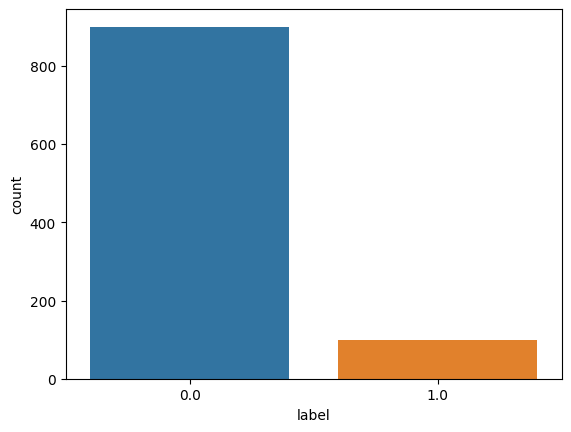

In [57]:
df = pd.read_csv('/kaggle/input/network-traffic-anomaly-detection-dataset/embedded_system_network_security_dataset.csv')

# Optional: Explore
print(df.shape)
print(df['label'].value_counts())  # Check imbalance
sns.countplot(x='label', data=df)


Label distribution:
 label
0.0    900
1.0    100
Name: count, dtype: int64


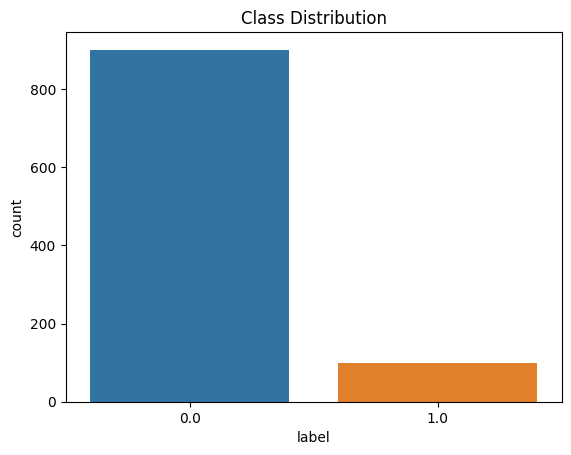

In [58]:
print("Label distribution:\n", df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and label
X = df.drop('label', axis=1)
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [60]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Fit Random Forest for feature importances
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)

# Select top 15 features
importances = rf.feature_importances_
top_indices = np.argsort(importances)[::-1][:15]
selected_features = X.columns[top_indices]

# Filter data with top features
X_train_selected = X_train_scaled[:, top_indices]
X_test_selected = X_test_scaled[:, top_indices]

print("Top 15 Selected Features:", list(selected_features))


Top 15 Selected Features: ['inter_arrival_time', 'spectral_entropy', 'frequency_band_energy', 'packet_size', 'src_port', 'packet_count_5s', 'dst_port', 'protocol_type_TCP', 'dst_ip_192.168.1.5', 'dst_ip_192.168.1.6', 'tcp_flags_SYN', 'src_ip_192.168.1.2', 'src_ip_192.168.1.3', 'protocol_type_UDP', 'tcp_flags_SYN-ACK']


In [61]:
from xgboost import XGBClassifier

# Handle class imbalance
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print("Imbalance Ratio:", imbalance_ratio)

# Train XGBoost
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio,
    random_state=42
)

xgb.fit(X_train_selected, y_train)
y_proba = xgb.predict_proba(X_test_selected)[:, 1]


Imbalance Ratio: 9.0


In [62]:
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold:", best_threshold)

# Predict using tuned threshold
y_pred_thresh = (y_proba >= best_threshold).astype(int)


Best Threshold: 0.102282666


In [63]:
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_thresh))
print("Classification Report:\n", classification_report(y_test, y_pred_thresh, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Macro F1 Score:", f1_score(y_test, y_pred_thresh, average='macro'))


Tuned Accuracy: 0.855
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       180
         1.0       0.30      0.35      0.33        20

    accuracy                           0.85       200
   macro avg       0.62      0.63      0.62       200
weighted avg       0.86      0.85      0.86       200

Confusion Matrix:
 [[164  16]
 [ 13   7]]
ROC AUC Score: 0.5922222222222222
Macro F1 Score: 0.6221744511758192


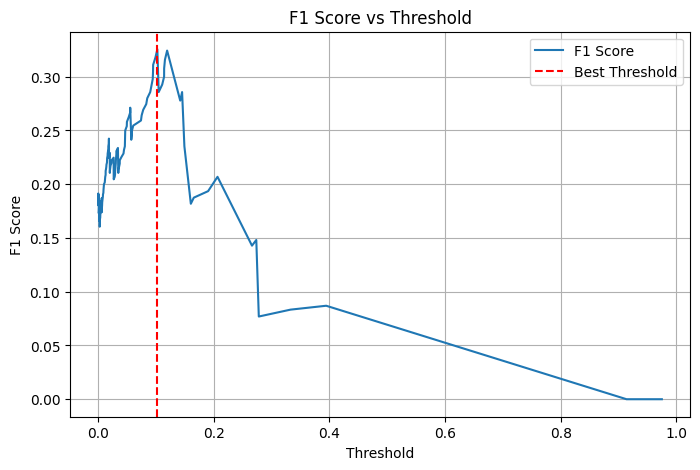

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label='Best Threshold')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=imbalance_ratio)
}


In [66]:
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score

results = []

for name, model in models.items():
    print(f"\n----- {name} -----")
    model.fit(X_train_selected, y_train)
    
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    
    # Threshold tuning
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_thresh = thresholds[np.argmax(f1_scores)]
    
    y_pred = (y_proba >= best_thresh).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, y_proba)

    print("Best Threshold:", best_thresh)
    print("Accuracy:", acc)
    print("F1 (macro):", f1)
    print("ROC AUC:", auc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Macro F1': f1,
        'ROC AUC': auc
    })



----- Logistic Regression -----
Best Threshold: 0.4863554866797899
Accuracy: 0.655
F1 (macro): 0.5488869275277042
ROC AUC: 0.6827777777777777
Confusion Matrix:
 [[114  66]
 [  3  17]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.63      0.77       180
         1.0       0.20      0.85      0.33        20

    accuracy                           0.66       200
   macro avg       0.59      0.74      0.55       200
weighted avg       0.90      0.66      0.72       200


----- SVM -----
Best Threshold: 0.09477830148959229
Accuracy: 0.2
F1 (macro): 0.1999199919991999
ROC AUC: 0.45083333333333336
Confusion Matrix:
 [[ 21 159]
 [  1  19]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.12      0.21       180
         1.0       0.11      0.95      0.19        20

    accuracy                           0.20       200
   macro avg       0.53      0.53      0.20       200

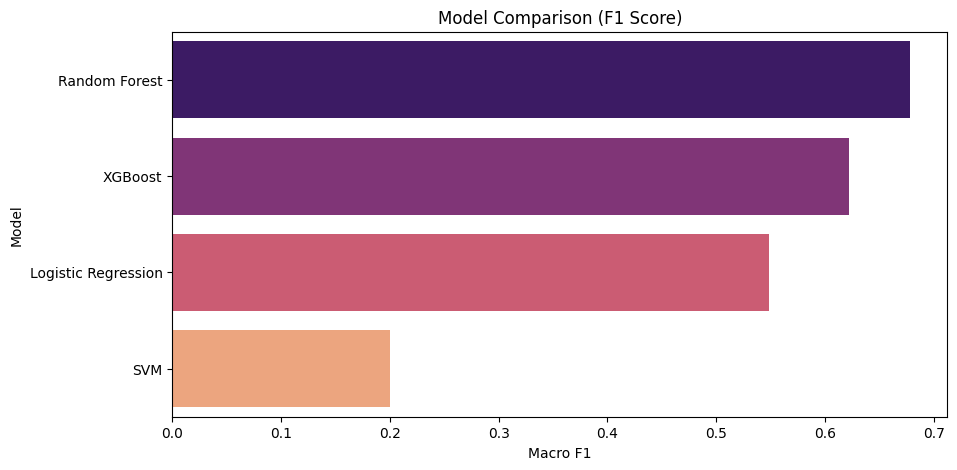

In [67]:
results_df = pd.DataFrame(results).sort_values(by='Macro F1', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x='Macro F1', y='Model', data=results_df, palette='magma')
plt.title("Model Comparison (F1 Score)")
plt.show()


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# 🔁 Retrain Random Forest with custom class weights
rf_tuned = RandomForestClassifier(
    n_estimators=100,
    class_weight={0: 1, 1: 5},  # Heavily penalize missing anomalies
    random_state=42
)
rf_tuned.fit(X_train_selected, y_train)

# 🔍 Predict probabilities
y_proba_rf = rf_tuned.predict_proba(X_test_selected)[:, 1]

# 📊 Threshold tuning
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

# 🧠 Predict using optimal threshold
y_pred_rf = (y_proba_rf >= best_threshold).astype(int)

# ✅ Evaluate
print("----- Random Forest (Weighted) -----")
print("Best Threshold:", best_threshold)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Macro F1:", f1_score(y_test, y_pred_rf, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))


----- Random Forest (Weighted) -----
Best Threshold: 0.15
Accuracy: 0.805
Macro F1: 0.612306774690591
ROC AUC: 0.6386111111111111
Confusion Matrix:
 [[151  29]
 [ 10  10]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.84      0.89       180
         1.0       0.26      0.50      0.34        20

    accuracy                           0.81       200
   macro avg       0.60      0.67      0.61       200
weighted avg       0.87      0.81      0.83       200



In [76]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_recall_curve, f1_score,
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score
)

# Step 1: Define base models (no calibration)
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    scale_pos_weight=imbalance_ratio, random_state=42)

# Step 2: Create soft-voting ensemble (raw models, no CalibratedClassifierCV)
voting_model = VotingClassifier(
    estimators=[
        ('LR', lr),
        ('RF', rf),
        ('XGB', xgb)
    ],
    voting='soft'
)

# Step 3: Fit ensemble
voting_model.fit(X_train_selected, y_train)

# Step 4: Predict probabilities and tune threshold
y_proba_voting = voting_model.predict_proba(X_test_selected)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_voting)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

# Step 5: Predict with tuned threshold
y_pred_voting = (y_proba_voting >= best_threshold).astype(int)

# Step 6: Evaluation
print("----- Soft Voting Ensemble (No Calibration) -----")
print("Best Threshold:", best_threshold)
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Macro F1:", f1_score(y_test, y_pred_voting, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_proba_voting))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_voting))
print("Classification Report:\n", classification_report(y_test, y_pred_voting, zero_division=0))


----- Soft Voting Ensemble (No Calibration) -----
Best Threshold: 0.24609903544411993
Accuracy: 0.82
Macro F1: 0.6370235934664247
ROC AUC: 0.7116666666666667
Confusion Matrix:
 [[153  27]
 [  9  11]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.85      0.89       180
         1.0       0.29      0.55      0.38        20

    accuracy                           0.82       200
   macro avg       0.62      0.70      0.64       200
weighted avg       0.88      0.82      0.84       200

